In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.python.data import Dataset
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read data

In [4]:
data = pd.read_csv("data/dengue_features_train.csv")

print data.shape
# data.columns

(1456, 24)


In [5]:
def convert_to_numeric_columns(dataset, cat_columns):
    for x in cat_columns:
        dataset[x] = dataset[x].astype('category')
    dataset[cat_columns] = dataset[cat_columns].apply(lambda x: x.cat.codes)
    return dataset

In [6]:
data = convert_to_numeric_columns(data, ['city', 'year'])
data = data.drop(columns = ['week_start_date'], axis=1)
np.array(data[["city", "year"]])

array([[ 1,  0],
       [ 1,  0],
       [ 1,  0],
       ...,
       [ 0, 20],
       [ 0, 20],
       [ 0, 20]], dtype=int8)

In [11]:
labels_inp = pd.read_csv("data/dengue_labels_train.csv")
labels_inp = convert_to_numeric_columns(labels_inp, ['city', 'year'])

print labels_inp.shape
labels_inp.columns

(1456, 4)


Index([u'city', u'year', u'weekofyear', u'total_cases'], dtype='object')

In [12]:
final_data =  pd.merge(data,
                 labels_inp,
                 on=['city', 'year', 'weekofyear'],
                      how='right')

# Define the label.
targets = final_data["total_cases"]

In [15]:
targets.shape

(1456,)

In [13]:

final_data = final_data[[u'city', u'year', u'weekofyear', u'ndvi_ne', u'ndvi_nw', u'ndvi_se',
       u'ndvi_sw', u'precipitation_amt_mm', u'reanalysis_air_temp_k',
       u'reanalysis_avg_temp_k', u'reanalysis_dew_point_temp_k',
       u'reanalysis_max_air_temp_k', u'reanalysis_min_air_temp_k',
       u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm']]
final_data.shape

(1456, 23)

In [14]:
values = {'city': -1, 'year': -1,
          'ndvi_ne': 0, 'ndvi_nw': 0, 'ndvi_se': 0, 'ndvi_sw': 0,
          'precipitation_amt_mm': 0, 'reanalysis_air_temp_k': 0, 'reanalysis_avg_temp_k': 0,
       'reanalysis_dew_point_temp_k': 0, 'reanalysis_max_air_temp_k': 0,
       'reanalysis_min_air_temp_k': 0, 'reanalysis_precip_amt_kg_per_m2': 0,
       'reanalysis_relative_humidity_percent': 0,
       'reanalysis_sat_precip_amt_mm': 0,
       'reanalysis_specific_humidity_g_per_kg': 0, 'reanalysis_tdtr_k': 0,
       'station_avg_temp_c': 0, 'station_diur_temp_rng_c': 0,
       'station_max_temp_c': 0, 'station_min_temp_c':0, 'station_precip_mm':0}
final_data = final_data.fillna(values)

# Train model

In [16]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def normalise_decimal_feature(feature):
    if isinstance(feature[0], float):
        return feature_normalize(feature)
    else:
        return feature

In [17]:
final_data = final_data.apply(lambda column: normalise_decimal_feature(column), axis=0)

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import genfromtxt

In [19]:
def read_dengAI_data():
    features = np.array(final_data)#["precipitation_amt_mm"]
    labels_arr = targets
    return features, labels_arr

In [20]:
features,labels = read_dengAI_data()

In [21]:
features.shape

(1456, 23)

In [22]:
def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [23]:
#  append_bias_reshape(features,labels)

In [161]:
f, l = append_bias_reshape(features,labels)
n_dim = f.shape[1]

rnd_indices = np.random.rand(len(f)) < 0.80

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]

In [164]:
learning_rate = 0.0000001
training_epochs = 100000
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.zeros([n_dim,1]))
# b = tf.Variable(tf.zeros([1]))

init = tf.initialize_all_variables()

In [165]:
y_ = tf.add(tf.matmul(X, W), b)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [166]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))

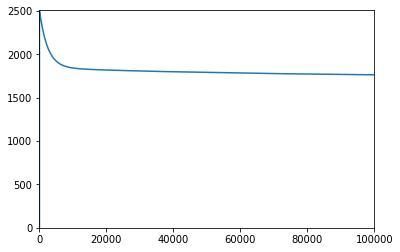

In [167]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 1780.7800


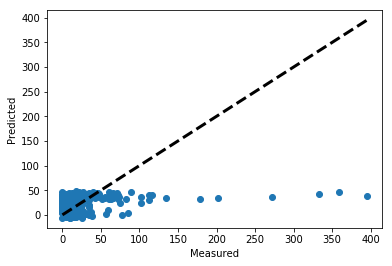

In [168]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_y, pred_y)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Generate test data results

In [30]:
data_test = pd.read_csv("data/dengue_features_test.csv")
data_test = data_test.drop("week_start_date", axis = 1)

print data_test.shape
data_test.columns

(416, 23)


Index([u'city', u'year', u'weekofyear', u'ndvi_ne', u'ndvi_nw', u'ndvi_se',
       u'ndvi_sw', u'precipitation_amt_mm', u'reanalysis_air_temp_k',
       u'reanalysis_avg_temp_k', u'reanalysis_dew_point_temp_k',
       u'reanalysis_max_air_temp_k', u'reanalysis_min_air_temp_k',
       u'reanalysis_precip_amt_kg_per_m2',
       u'reanalysis_relative_humidity_percent',
       u'reanalysis_sat_precip_amt_mm',
       u'reanalysis_specific_humidity_g_per_kg', u'reanalysis_tdtr_k',
       u'station_avg_temp_c', u'station_diur_temp_rng_c',
       u'station_max_temp_c', u'station_min_temp_c', u'station_precip_mm'],
      dtype='object')

In [31]:
index_result = data_test[['city', 'year', "weekofyear"]]

In [32]:
data_test = convert_to_numeric_columns(data_test, ['city', 'year'])
final_data_test = data_test.apply(lambda column: normalise_decimal_feature(column), axis=0)
features_test = np.array(final_data_test)

In [33]:
# final_data_test

In [34]:
pred_y_test = sess.run(y_, feed_dict={X: data_test})

ValueError: Cannot feed value of shape (416, 23) for Tensor u'Placeholder:0', which has shape '(?, 24)'

In [ ]:
pred_y_test.shape

In [ ]:
index_result["total_cases"] = pred_y_test

In [115]:
sess.close()